C:\Users\martdave\AppData\Local\anaconda3\envs\bubbleid\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f,

Cropping: x from 262 to 1542, y from 614 to 1894
Cropped shape: (1280, 1280, 3)
Saved cropped image: C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_cropped.tif


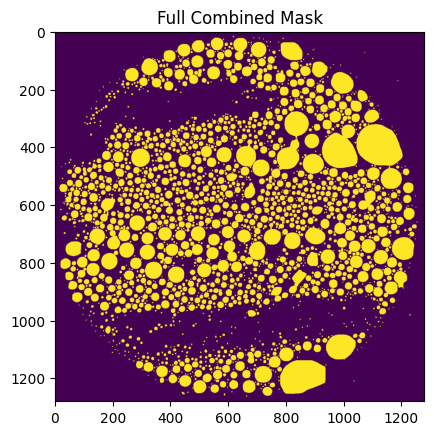

Saved combined full mask: C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_fullmask.png
Saved mask (tif): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_mask.tif
Saved overlay with fitted circles (png): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_circles.png
Saved droplet diameters (txt): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_diameters.txt


In [24]:
# ------------- LOADING MODEL ----------------------
import cv2
import os
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import numpy as np
import torch
from detectron2.data import MetadataCatalog, DatasetCatalog

# DatasetCatalog.register("bubble_dataset", lambda: [])
# MetadataCatalog.get("bubble_dataset").set(thing_classes=["bubble","bubble"])
# cfg.DATASETS.TRAIN = ("bubble_dataset",)

cfg = get_cfg()
cfg.OUTPUT_DIR = "./"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000  # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./condensation1/model_best.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, r"E:\Dave\Everything for bubble ID\Trained model\model_1class.pth")  # path to the model we just trained
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "./final_flipped.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set a custom testing threshold

predictor = DefaultPredictor(cfg)

# --------------------LOAD IMAGE --------------------------
image_path = r"C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169.tif"
# image_path = "./samesurface2.tif"
# image_path = "./othersurface1.tif"
image = cv2.imread(image_path)

import tifffile  # Needed for saving .tif if you want a high-fidelity save of grayscale, etc.

# --- Define crop box (replace these numbers as needed) ---
x_min, y_min = 262, 614  # BOTTOM LEFT (x, y)
x_max, y_max = 1542, 1894  # TOP RIGHT (x, y)
print(f"Cropping: x from {x_min} to {x_max}, y from {y_min} to {y_max}")

# --- Crop the image ---
cropped_image = image[y_min:y_max, x_min:x_max]
print(f"Cropped shape: {cropped_image.shape}")

# --- Save the cropped image ---
input_dir = os.path.dirname(image_path)
base_name = os.path.splitext(os.path.basename(image_path))[0]
cropped_img_path = os.path.join(input_dir, f"{base_name}_cropped.tif")

# If your image is RGB use this; for single channel (grayscale) you can use tifffile.
# The line below is OK for both, but tifffile can preserve more channel info for grayscale.
cv2.imwrite(cropped_img_path, cropped_image)
print(f"Saved cropped image: {cropped_img_path}")

# --- USE THE CROPPED IMAGE for ALL DOWNSTREAM PROCESSING ---
image = cropped_image
# ------------------ INITIAL CROP------------------------------------
rows = 6
cols = 8
crop_h = image.shape[0] // rows
crop_w = image.shape[1] // cols
fullimg = np.empty((rows, cols), dtype=object)

for k in range(rows):
    for j in range(cols):
        outputs = predictor(image[(k*crop_h):(k*crop_h)+crop_h, (j*crop_w):(j*crop_w)+crop_w])  # <-- original was (kcrop_h), should be (k*crop_h)
        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:  # 'elif len(masks)==0:' not required, just 'else'
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols)], axis=1) for i in range(rows)]  # <-- originally [fullimg[i, j] for j in range(8)], which is correct only if cols==8
full_image = np.concatenate(img_rows, axis=0)

bottom_pad = np.zeros((image.shape[0]-(crop_h*rows), full_image.shape[1]), dtype=bool)
full_image = np.concatenate([full_image.astype(bool), bottom_pad], axis=0)

right_pad = np.zeros((full_image.shape[0], image.shape[1]-(crop_w*cols)), dtype=bool)
full_image = np.concatenate([full_image, right_pad], axis=1)

plt.imshow(full_image)

# ------------ CROP SHIFT RIGHT ---------------------
fullimg = np.empty((rows, cols-1), dtype=object)

for k in range(rows):
    for j in range(cols-1):
        outputs = predictor(image[(k*crop_h):(k*crop_h)+crop_h, (j*crop_w)+(crop_w//2):(j*crop_w)+crop_w+(crop_w//2)])  # <-- indices corrected

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols-1)], axis=1) for i in range(rows)]
full_image1 = np.concatenate(img_rows, axis=0)

left_pad = np.zeros((full_image1.shape[0], crop_w // 2), dtype=bool)
add = 0
if crop_w % 2 == 1:
    add = 1
right_pad = np.zeros((full_image1.shape[0], (crop_w // 2) + image.shape[1] - (crop_w*cols) + add), dtype=bool)
full_image1 = np.concatenate([left_pad, full_image1, right_pad], axis=1)

bottom_pad = np.zeros((image.shape[0]-(crop_h*rows), full_image1.shape[1]), dtype=bool)
full_image1 = np.concatenate([full_image1.astype(bool), bottom_pad], axis=0)

plt.imshow(full_image1)

# ---------------- CROP SHIFT DOWN -------------------------
fullimg = np.empty((rows-1, cols), dtype=object)

for k in range(rows-1):
    for j in range(cols):
        outputs = predictor(
            image[
                (k*crop_h)+(crop_h//2):(k*crop_h)+crop_h+(crop_h//2),  # <-- fixed index
                (j*crop_w):(j*crop_w)+crop_w                           # <-- fixed index
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols)], axis=1) for i in range(rows-1)]
full_image2 = np.concatenate(img_rows, axis=0)
add = 0
if crop_h % 2 == 1:
    add = 1
top_pad = np.zeros((crop_h // 2, full_image2.shape[1]), dtype=bool)
bottom_pad = np.zeros((crop_h//2 + image.shape[0] - (crop_h*rows) + add, full_image2.shape[1]), dtype=bool)  # add one
full_image2 = np.concatenate([top_pad, full_image2.astype(bool), bottom_pad], axis=0)

right_pad = np.zeros((full_image2.shape[0], image.shape[1]-(crop_w*cols)), dtype=bool)
full_image2 = np.concatenate([full_image2, right_pad], axis=1)

plt.imshow(full_image2)

# --------------------- CROP SHIFT DOWN AND RIGHT --------------------
fullimg = np.empty((rows-1, cols-1), dtype=object)

for k in range(rows-1):
    for j in range(cols-1):
        outputs = predictor(
            image[
                (k*crop_h)+(crop_h//2):(k*crop_h)+crop_h+(crop_h//2),   # <-- fixed index
                (j*crop_w)+(crop_w//2):(j*crop_w)+crop_w+(crop_w//2)    # <-- fixed index
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols-1)], axis=1) for i in range(rows-1)]
full_image3 = np.concatenate(img_rows, axis=0)
add = 0
if crop_h % 2 == 1:
    add = 1
top_pad = np.zeros((crop_h // 2, full_image3.shape[1]), dtype=bool)
bottom_pad = np.zeros((crop_h//2 + image.shape[0] - (crop_h*rows) + add, full_image3.shape[1]), dtype=bool)  # add one
full_image3 = np.concatenate([top_pad, full_image3.astype(bool), bottom_pad], axis=0)
add = 0
if crop_w % 2 == 1:
    add = 1
left_pad = np.zeros((full_image3.shape[0], crop_w // 2), dtype=bool)
right_pad = np.zeros((full_image3.shape[0], (crop_w // 2) + image.shape[1] - (crop_w*cols) + add), dtype=bool)  # add one

full_image3 = np.concatenate([left_pad, full_image3, right_pad], axis=1)

plt.imshow(full_image3)

full_mask = full_image | full_image1 | full_image2 | full_image3
plt.imshow(full_mask)

# ------------------- CROP LARGER ----------------------
rows = 3
cols = 4
crop_h = image.shape[0] // rows
crop_w = image.shape[1] // cols
fullimg = np.empty((rows, cols), dtype=object)

for k in range(rows):
    for j in range(cols):
        outputs = predictor(
            image[
                (k*crop_h):(k*crop_h)+crop_h,      # <-- fixed index
                (j*crop_w):(j*crop_w)+crop_w       # <-- fixed index
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols)], axis=1) for i in range(rows)]
full_image4 = np.concatenate(img_rows, axis=0)

bottom_pad = np.zeros((image.shape[0]-(crop_h*rows), full_image4.shape[1]), dtype=bool)
full_image4 = np.concatenate([full_image4.astype(bool), bottom_pad], axis=0)   # <-- be sure rows*crop_h <= image.shape[0]

right_pad = np.zeros((full_image4.shape[0], image.shape[1]-(crop_w*cols)), dtype=bool)
full_image4 = np.concatenate([full_image4, right_pad], axis=1)

plt.imshow(full_image4)

# --------------------- CROP LARGE SHIFT RIGHT --------------------------
fullimg = np.empty((rows, cols-1), dtype=object)

for k in range(rows):
    for j in range(cols-1):
        outputs = predictor(
            image[
                (k*crop_h):(k*crop_h)+crop_h,           # <-- fixed
                (j*crop_w)+(crop_w//2):(j*crop_w)+crop_w+(crop_w//2)   # <-- fixed
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols-1)], axis=1) for i in range(rows)]
full_image5 = np.concatenate(img_rows, axis=0)

left_pad = np.zeros((full_image5.shape[0], crop_w // 2), dtype=bool)
add = 0
if crop_w % 2 == 1:
    add = 1
right_pad = np.zeros((full_image5.shape[0], (crop_w // 2) + image.shape[1] - (crop_w*cols) + add), dtype=bool)
full_image5 = np.concatenate([left_pad, full_image5, right_pad], axis=1)

bottom_pad = np.zeros((image.shape[0]-(crop_h*rows), full_image5.shape[1]), dtype=bool)
full_image5 = np.concatenate([full_image5.astype(bool), bottom_pad], axis=0)

plt.imshow(full_image5)

# ------------------------ CROP LARGE SHIFT DOWN ---------------------
fullimg = np.empty((rows-1, cols), dtype=object)

for k in range(rows-1):
    for j in range(cols):
        outputs = predictor(
            image[
                (k*crop_h)+(crop_h//2):(k*crop_h)+crop_h+(crop_h//2),  # <-- fixed index
                (j*crop_w):(j*crop_w)+crop_w                          # <-- fixed index
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb = outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols)], axis=1) for i in range(rows-1)]
full_image6 = np.concatenate(img_rows, axis=0)

add = 0
if crop_h % 2 == 1:
    add = 1
top_pad = np.zeros((crop_h // 2, full_image6.shape[1]), dtype=bool)
bottom_pad = np.zeros((crop_h//2 + image.shape[0] - (crop_h*rows) + add, full_image6.shape[1]), dtype=bool)
full_image6 = np.concatenate([top_pad, full_image6.astype(bool), bottom_pad], axis=0)

right_pad = np.zeros((full_image6.shape[0], image.shape[1]-(crop_w*cols)), dtype=bool)
full_image6 = np.concatenate([full_image6, right_pad], axis=1)

plt.imshow(full_image6)

# --------------- CROP LARGE SHIFT DOWN AND RIGHT ----------------
fullimg = np.empty((rows-1, cols-1), dtype=object)

for k in range(rows-1):
    for j in range(cols-1):
        outputs = predictor(
            image[
                (k*crop_h)+(crop_h//2):(k*crop_h)+crop_h+(crop_h//2),
                (j*crop_w)+(crop_w//2):(j*crop_w)+crop_w+(crop_w//2)
            ]
        )

        # Get the prediction masks as a CPU tensor
        masks = outputs['instances'].pred_masks.cpu()
        bb=outputs['instances'].pred_boxes

        for l in range(len(bb)-1, -1, -1):
            if bb[l].tensor.cpu().tolist()[0][0] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][1] < 10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][2] > crop_w-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)
            elif bb[l].tensor.cpu().tolist()[0][3] > crop_h-10:
                masks = torch.cat((masks[:l], masks[l+1:]), dim=0)

        if len(masks) > 0:
            combined_mask = torch.zeros_like(masks[0], dtype=torch.bool)
            for i in range(len(masks)):
                if masks[i].sum().item() < (crop_h*crop_w)//3:
                    combined_mask |= masks[i]
        else:
            combined_mask = torch.zeros((crop_h, crop_w), dtype=torch.bool)

        fullimg[k, j] = combined_mask

img_rows = [np.concatenate([fullimg[i, j] for j in range(cols-1)], axis=1) for i in range(rows-1)]
full_image7 = np.concatenate(img_rows, axis=0)

add = 0
if crop_h % 2 == 1:
    add = 1
top_pad = np.zeros((crop_h // 2, full_image7.shape[1]), dtype=bool)
bottom_pad = np.zeros((crop_h//2 + image.shape[0] - (crop_h*rows) + add, full_image7.shape[1]), dtype=bool)
full_image7 = np.concatenate([top_pad, full_image7.astype(bool), bottom_pad], axis=0)
add = 0
if crop_w % 2 == 1:
    add = 1
left_pad = np.zeros((full_image7.shape[0], crop_w // 2), dtype=bool)
right_pad = np.zeros((full_image7.shape[0], (crop_w // 2) + image.shape[1] - (crop_w*cols) + add), dtype=bool)
full_image7 = np.concatenate([left_pad, full_image7, right_pad], axis=1)

plt.imshow(full_image7)

full_mask = (full_image | full_image1 | full_image2 | full_image3 | 
             full_image4 | full_image5 | full_image6 | full_image7)
plt.imshow(full_mask)
# plt.savefig("samesurface1_mask1.png")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
# import other necessary packages:
# from scipy.ndimage import distance_transform_edt, maximum_filter, label as ndi_label
# from skimage.measure import regionprops
# from skimage.segmentation import watershed

# ... your code above ...

# Combine all shifted/stitch crops to make full_mask
full_mask = full_image | full_image1 | full_image2 | full_image3 | full_image4 | full_image5 | full_image6 | full_image7

# Optionally display
plt.imshow(full_mask)
plt.title("Full Combined Mask")
plt.show()

# ---- SAVE the full_mask with custom colormap ----
# Create a custom colormap: purple background ([128, 0, 128]), yellow objects ([255, 255, 0])
mask_rgb = np.zeros((*full_mask.shape, 3), dtype=np.uint8)
mask_rgb[full_mask == 0] = [128, 0, 128]  # Purple background
mask_rgb[full_mask == 1] = [255, 255, 0]  # Yellow objects

# Build output path
input_dir = os.path.dirname(image_path)
base_name = os.path.splitext(os.path.basename(image_path))[0]
fullmask_path = os.path.join(input_dir, f"{base_name}_fullmask.png")

# Save as PNG (alternatively use cv2.imwrite for .tif if desired)
cv2.imwrite(fullmask_path, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))
print(f"Saved combined full mask: {fullmask_path}")

# ========== NEW STRATEGY STARTS HERE ==========

# -------------- MARKER-BASED WATERSHED SPLITTING (The Bridge) --------------
mask_uint8 = (full_mask > 0).astype(np.uint8) * 255
contour_data = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
clusters = contour_data[0] if len(contour_data) == 2 else contour_data[1]

split_label_mask = np.zeros_like(mask_uint8, dtype=np.int32)
current_label = 1

for cluster in clusters:
    cluster_mask = np.zeros_like(mask_uint8)
    cv2.drawContours(cluster_mask, [cluster], -1, 255, -1)
    cluster_bool = cluster_mask > 0
    dist = distance_transform_edt(cluster_bool)
    local_max = (dist == maximum_filter(dist, size=15)) & (dist > 0)
    markers_labeled, n_markers = ndi_label(local_max.astype(np.uint8))
    if n_markers <= 1:
        split_label_mask[cluster_bool] = current_label
        current_label += 1
        continue
    labels = watershed(-dist, markers=markers_labeled, mask=cluster_bool)
    for sublabel in range(1, labels.max() + 1):
        split_label_mask[(labels == sublabel)] = current_label
        current_label += 1

# -------------- REGIONPROPS & SAVE RESULTS (The End) --------------
regions = regionprops(split_label_mask)
diameters = [region.equivalent_diameter for region in regions]

# Output file paths
input_dir = os.path.dirname(image_path)
base_name = os.path.splitext(os.path.basename(image_path))[0]
tif_path = os.path.join(input_dir, f"{base_name}_mask.tif")
circles_img_path = os.path.join(input_dir, f"{base_name}_circles.png")
diameter_txt_path = os.path.join(input_dir, f"{base_name}_diameters.txt")

# --- CREATE & SAVE CIRCLE-FITTING/OVERLAY IMAGE ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(split_label_mask > 0, cmap='gray')
for region in regions:
    y, x = region.centroid
    ediam = region.equivalent_diameter
    circ = plt.Circle((x, y), ediam / 2, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(circ)
ax.set_axis_off()
fig.tight_layout()
plt.savefig(circles_img_path, bbox_inches='tight', pad_inches=0)
plt.close(fig)

# --- SAVE DIAMETERS AS TEXT FILE ---
np.savetxt(diameter_txt_path, diameters)

print(f"Saved mask (tif): {tif_path}")
print(f"Saved overlay with fitted circles (png): {circles_img_path}")
print(f"Saved droplet diameters (txt): {diameter_txt_path}")

In [25]:
import numpy as np
import cv2
import tifffile
import os
import matplotlib.pyplot as plt

# --- USER-SPECIFIED FOV from original image ---
fov_xmin_orig, fov_xmax_orig = 839, 955
fov_ymin_orig, fov_ymax_orig = 1460, 1579

# --- CROP ORIGIN from cell one ---
# x_min, y_min set above as 262, 614 -- do NOT change these here!

# --- Convert to cropped image coordinates ---
fov_xmin = fov_xmin_orig - x_min
fov_xmax = fov_xmax_orig - x_min
fov_ymin = fov_ymin_orig - y_min
fov_ymax = fov_ymax_orig - y_min

print(f"Working with FOV on cropped image: x:{fov_xmin}:{fov_xmax}, y:{fov_ymin}:{fov_ymax}")
print(f"Image shape: {image.shape}")

# --- Check bounds ---
H, W = image.shape[:2]
if not (0 <= fov_xmin < fov_xmax <= W) or not (0 <= fov_ymin < fov_ymax <= H):
    raise ValueError("FOV crop indices are out of bounds! Please check input.")

# --- Now crop your FOV in image and mask, then proceed as before ---
fov_img = image[fov_ymin:fov_ymax, fov_xmin:fov_xmax]
# etc: use fov_img, and the same slices for masks/overlays as in prior cell

# ========== 1. Crop the image in the FOV region ==========
fov_img = image[fov_ymin:fov_ymax, fov_xmin:fov_xmax]
fov_img_path = os.path.join(input_dir, f"{base_name}_FOV_image.tif")
tifffile.imwrite(fov_img_path, fov_img)  # Use tifffile to preserve depth/channels

# ========== 2. Find regions whose centroid is inside the FOV ==========
fov_regions = []
fov_indices = []
fov_mask = np.zeros_like(full_mask, dtype=bool)
for idx, region in enumerate(regions):
    y, x = region.centroid
    if fov_ymin <= y < fov_ymax and fov_xmin <= x < fov_xmax:
        fov_regions.append(region)
        fov_indices.append(idx)
        fov_mask[full_mask == region.label] = True

# Crop the FOV mask to the FOV region
cropped_fov_mask = fov_mask[fov_ymin:fov_ymax, fov_xmin:fov_xmax]

# Color FOV mask: purple background, yellow objects
mask_rgb_fov = np.zeros((*cropped_fov_mask.shape, 3), dtype=np.uint8)
mask_rgb_fov[cropped_fov_mask == 0] = [128, 0, 128]
mask_rgb_fov[cropped_fov_mask == 1] = [255, 255, 0]
fov_mask_path = os.path.join(input_dir, f"{base_name}_FOV_mask.png")
cv2.imwrite(fov_mask_path, cv2.cvtColor(mask_rgb_fov, cv2.COLOR_RGB2BGR))

# ========== 3. FOV circles overlay ==========
fov_circles_path = os.path.join(input_dir, f"{base_name}_FOV_circles.png")
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cropped_fov_mask, cmap="gray", alpha=0.3)
ax.imshow(fov_img, alpha=0.8)
for region in fov_regions:
    y, x = region.centroid
    ediam = region.equivalent_diameter
    # Draw only if centroid within cropped FOV
    circ = plt.Circle((x-fov_xmin, y-fov_ymin), ediam/2, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(circ)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(fov_circles_path, bbox_inches='tight', pad_inches=0)
plt.close(fig)

# ========== 4. Save FOV diameters ==========
fov_diameters = np.array([region.equivalent_diameter for region in fov_regions])
fov_diam_path = os.path.join(input_dir, f"{base_name}_FOV_diameters.txt")
np.savetxt(fov_diam_path, fov_diameters)

print(f"Saved FOV cropped image (tif): {fov_img_path}")
print(f"Saved FOV mask (png): {fov_mask_path}")
print(f"Saved FOV overlay with fitted circles (png): {fov_circles_path}")
print(f"Saved FOV droplet diameters (txt): {fov_diam_path}")

Working with FOV on cropped image: x:577:693, y:846:965
Image shape: (1280, 1280, 3)
Saved FOV cropped image (tif): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_FOV_image.tif
Saved FOV mask (png): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_FOV_mask.png
Saved FOV overlay with fitted circles (png): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_FOV_circles.png
Saved FOV droplet diameters (txt): C:\Users\martdave\Downloads\Growth rate and Rmax_estimation\8T_#5\T.chill.6_1_169_FOV_diameters.txt
